# IMPORT

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf #tensorflow
import numpy as np #numpy > save loss .. 
from collections import OrderedDict #layer ..
import os, random #dir, random..
import pickle #save & load
%matplotlib inline
from matplotlib import pyplot as plt

print(tf.__version__)

1.0.1


# PATH

In [2]:
#path
#DATA_PATH = './cifar10/cifar-10-batches-py/' #python pickle
DATA_PATH = './cifar10/cifar-10-batches-bin/' #binary
CHECKPOINT = 'simple_res_net_0529.ckpt'
SAVE_PATH = './checkpoint/res_0529/'
BOARD_PATH = './tensorboard/board_res_0529'
TEST_FILE_PATH='./cifar10/cifar-10-batches-py/test_batch'

# PARAMETERS

In [3]:
#parameters

INPUT_SIDE = 32
INPUT_SIZE = INPUT_SIDE * INPUT_SIDE
N_CHANNEL = 3
BATCH_SIZE = 64
EPOCHS = 10000
LR = 0.1
LR_DECAY_RATE = 0.5

LABEL_BYTES = 1 
NUM_EXAMPLES_PER_EPOCH = 50000 #NUMBER OF TRAIN DATA SET
NUM_BATCHES_PER_EPOCH = NUM_EXAMPLES_PER_EPOCH / BATCH_SIZE
NUM_TESTSET_PER_EPOCH = 10000
NUM_TEST_BATCHES_PER_EPOCH = NUM_TESTSET_PER_EPOCH / BATCH_SIZE

LIST_CLASS=['airplane', 'automobile', 'birds', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
N_CLASSES = len(LIST_CLASS)

#loss & accuracy save (pickle)
OUT_FILE_NAME = 'RES_NET_CIFAR10_0529.log'
loss_out = open('LOSS'+OUT_FILE_NAME, 'w')
accr_out = open('ACCURACY'+OUT_FILE_NAME, 'w')

print("input image size : {}".format(INPUT_SIZE))
print("image channel : {}".format(N_CHANNEL))
print("batch size : {}".format(BATCH_SIZE))
print("num of class : {}".format(N_CLASSES))
print("training epochs : {}".format(EPOCHS))
print("learning rate : {}".format(LR))
print("learning decay rate : {}".format(LR_DECAY_RATE))

input image size : 1024
image channel : 3
batch size : 64
num of class : 10
training epochs : 10000
learning rate : 0.1
learning decay rate : 0.5


# FUNCTIONS

In [4]:
#Batch Normalization - tf.nn.batch_normalization
def batch_norm(x, n_out, phase_train, scope='bn'):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    
    with tf.variable_scope(scope):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)
        if phase_train:
            mean, var = mean_var_with_update()
        else:
            mean = ema.average(batch_mean)
            var = ema.average(batch_var)

        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

#CIFAR 데이터 읽어오기 
def read_dataset(filename_queue):
    class DataRecord(object):
        pass
    
    result = DataRecord()
    
    label_bytes = LABEL_BYTES
    result.height = INPUT_SIDE
    result.width = INPUT_SIDE
    result.depth = N_CHANNEL
    image_bytes = result.height * result.width * result.depth
    record_bytes = label_bytes + image_bytes
    
    reader = tf.FixedLengthRecordReader(record_bytes = record_bytes)
    result.key, value = reader.read(filename_queue)
    print (value)
    record_bytes = tf.decode_raw(value, tf.uint8)
    
    result.label = tf.cast(tf.strided_slice(record_bytes, [0], [label_bytes]), tf.int32) #input, begin, end로 잘라냄 > 0~1
    
    depth_major = tf.reshape(tf.strided_slice(record_bytes, [label_bytes], # 1부터 image_bytes까지 image를 잘라낸 후 
                                              [label_bytes + image_bytes]), #channel x height x width로 변환함.
                             [result.depth, result.height, result.width])
    
    result.uint8image = tf.transpose(depth_major, [1,2,0]) #channel x height x width >>> height x width x chennl로 변경
    
    return result

#label, image 세팅해줌 
def _generate_image_and_label_batch(image, label, min_queue_examples,
                                    batch_size, shuffle):
    """Construct a queued batch of images and labels.
    Args:
      image: 3-D Tensor of [height, width, 3] of type.float32.
      label: 1-D Tensor of type.int32
      min_queue_examples: int32, minimum number of samples to retain
        in the queue that provides of batches of examples.
      batch_size: Number of images per batch.
      shuffle: boolean indicating whether to use a shuffling queue.
    Returns:
      images: Images. 4D tensor of [batch_size, height, width, 3] size.
      labels: Labels. 1D tensor of [batch_size] size.
    """
    # Create a queue that shuffles the examples, and then
    # read 'batch_size' images + labels from the example queue.
    num_preprocess_threads = 16 #프로세스 스레드 
    if shuffle: #셔플 하면 
        images, label_batch = tf.train.shuffle_batch([image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size,
            min_after_dequeue=min_queue_examples) #이거만 해주면 batch와 동일함. 
    #Minimum number elements in the queue after a dequeue, used to ensure a level of mixing of elements.
    else:
        images, label_batch = tf.train.batch([image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size)

    # Display the training images in the visualizer.
    tf.summary.image('images', images) #걍 보드용인듯

    return images, tf.reshape(label_batch, [batch_size])


def distorted_inputs(data_dir, batch_size): #좀 드럽게 인풋받아오기 
    """Construct distorted input for CIFAR training using the Reader ops.
    Args:
      data_dir: Path to the CIFAR-10 data directory.
      batch_size: Number of images per batch.
    Returns:
      images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
      labels: Labels. 1D tensor of [batch_size] size.
    """
    filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i) for i in range(1, 6)] 
    for f in filenames:
        if not tf.gfile.Exists(f):
            raise ValueError('Failed to find file: ' + f)

    # Create a queue that produces the filenames to read.
    filename_queue = tf.train.string_input_producer(filenames)

    # Read examples from files in the filename queue.
    read_input = read_dataset(filename_queue)
    reshaped_image = tf.cast(read_input.uint8image, tf.float32)

    height = INPUT_SIDE
    width = INPUT_SIDE

    # Image processing for training the network.  Note the many random
    # distortions applied to the image.

    # Randomly crop a [height, width] section of the image.
    distorted_image = tf.random_crop(reshaped_image, [height, width, 3])

    # Randomly flip the image horizontally.
    distorted_image = tf.image.random_flip_left_right(distorted_image)

    # Because these operations are not commutative, consider randomizing
    # the order their operation.
    distorted_image = tf.image.random_brightness(distorted_image,
                                               max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image,
                                             lower=0.2, upper=1.8)

    # Subtract off the mean and divide by the variance of the pixels.
    float_image = tf.image.per_image_standardization(distorted_image)

    # Set the shapes of tensors.
    float_image.set_shape([height, width, 3])
    read_input.label.set_shape([1])

    # Ensure that the random shuffling has good mixing properties.
    min_fraction_of_examples_in_queue = 0.4
    min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH * min_fraction_of_examples_in_queue)
    print('Filling queue with %d CIFAR images before starting to train. '
         'This will take a few minutes.' % min_queue_examples)

    # Generate a batch of images and labels by building up a queue of examples.
    return _generate_image_and_label_batch(float_image, read_input.label,
                                         min_queue_examples, batch_size,
                                         shuffle=True)


def inputs(eval_data, data_dir, batch_size):
    """Construct input for CIFAR evaluation using the Reader ops.
    Args:
    eval_data: bool, indicating if one should use the train or eval data set.
    data_dir: Path to the CIFAR-10 data directory.
    batch_size: Number of images per batch.
    Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
    """
    if not eval_data:
        filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i)
                     for i in xrange(1, 6)]
        num_examples_per_epoch = NUM_EXAMPLES_PER_EPOCH
    else:
        filenames = [os.path.join(data_dir, 'test_batch.bin')]
        num_examples_per_epoch = NUM_TESTSET_PER_EPOCH

    for f in filenames:
        if not tf.gfile.Exists(f):
             raise ValueError('Failed to find file: ' + f)

    # Create a queue that produces the filenames to read.
    filename_queue = tf.train.string_input_producer(filenames)

    # Read examples from files in the filename queue.
    read_input = read_dataset(filename_queue)
    reshaped_image = tf.cast(read_input.uint8image, tf.float32)

    height = INPUT_SIDE
    width = INPUT_SIDE

    # Image processing for evaluation.
    # Crop the central [height, width] of the image.
    resized_image = tf.image.resize_image_with_crop_or_pad(reshaped_image,
                                                         height, width)

    # Subtract off the mean and divide by the variance of the pixels.
    float_image = tf.image.per_image_standardization(resized_image)

    # Set the shapes of tensors.
    float_image.set_shape([height, width, 3])
    read_input.label.set_shape([1])

    # Ensure that the random shuffling has good mixing properties.
    min_fraction_of_examples_in_queue = 0.4
    min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH * min_fraction_of_examples_in_queue)

    # Generate a batch of images and labels by building up a queue of examples.
    return _generate_image_and_label_batch(float_image, read_input.label,
                                         min_queue_examples, batch_size,
                                         shuffle=False)


print("FUNCTIONS READY")

FUNCTIONS READY


# NETWORK PARAMETERS

In [5]:
#NETWORK PARAMETERS

stddev = 0.1

weights = {
    'conv' : tf.Variable(tf.random_normal([3, 3, N_CHANNEL, 16], stddev=stddev), name='conv'),
    'conv1_1x1' : tf.Variable(tf.random_normal([1, 1, 16, 4], stddev=stddev, name='conv1_1x1')),
    'conv1_3x3' : tf.Variable(tf.random_normal([3, 3, 4, 4], stddev=stddev, name='conv1_3x3')),
    'conv1_1x1_16' : tf.Variable(tf.random_normal([1, 1, 4, 16], stddev=stddev, name='conv1_1x1_16')),
    'conv2_1x1' : tf.Variable(tf.random_normal([1, 1, 16, 4], stddev=stddev, name='conv2_1x1')),
    'conv2_3x3' : tf.Variable(tf.random_normal([3, 3, 4, 4], stddev=stddev, name='conv2_3x3')),
    'conv2_1x1_16' : tf.Variable(tf.random_normal([1, 1, 4, 16], stddev=stddev, name='conv2_1x1_16')),
    
    # conv 16 + conv2 16 = 32filters 
    
    'conv3_1x1' : tf.Variable(tf.random_normal([1, 1, 32, 8], stddev=stddev, name='conv3_1x1')),
    'conv3_3x3' : tf.Variable(tf.random_normal([3, 3, 8, 8], stddev=stddev, name='conv3_3x3')),
    'conv3_1x1_32' : tf.Variable(tf.random_normal([1, 1, 8, 32], stddev=stddev, name='conv3_1x1_32')),
    'conv4_1x1' : tf.Variable(tf.random_normal([1, 1, 32, 8], stddev=stddev, name='conv4_1x1')),
    'conv4_3x3' : tf.Variable(tf.random_normal([3, 3, 8, 8], stddev=stddev, name='conv4_3x3')),
    'conv4_1x1_32' : tf.Variable(tf.random_normal([1, 1, 8, 32], stddev=stddev, name='conv4_1x1_32')),
    
    # conv2 지난거32 + conv4 32 = 64
    
    'conv5_1x1' : tf.Variable(tf.random_normal([1, 1, 64, 16], stddev=stddev, name='conv5_1x1')),
    'conv5_3x3' : tf.Variable(tf.random_normal([3, 3, 16, 16], stddev=stddev, name='conv5_3x3')),
    'conv5_1x1_64' : tf.Variable(tf.random_normal([1, 1, 16, 64], stddev=stddev, name='conv5_1x1_64')),
    'conv6_1x1' : tf.Variable(tf.random_normal([1, 1, 64, 16], stddev=stddev, name='conv6_1x1')),
    'conv6_3x3' : tf.Variable(tf.random_normal([3, 3, 16, 16], stddev=stddev, name='conv6_3x3')),
    'conv6_1x1_64' : tf.Variable(tf.random_normal([1, 1, 16, 64], stddev=stddev, name='conv6_1x1_64')),
    
    #conv4 지난거 64 + conv6 64 = 128
    
    'dense1' : tf.Variable(tf.random_normal([16*16*128, 1000], stddev=stddev, name='dense1')),
    'dense2' : tf.Variable(tf.random_normal([1000, N_CLASSES], stddev=stddev, name='dense2'))    
}
biases = {
    'conv' : tf.Variable(tf.random_normal([16], stddev=stddev, name='conv_b')),
    'conv1_1x1' : tf.Variable(tf.random_normal([4], stddev=stddev, name='conv1_1x1_b')),
    'conv1_3x3' : tf.Variable(tf.random_normal([4], stddev=stddev, name='conv1_3x3_b')),
    'conv1_1x1_16' : tf.Variable(tf.random_normal([16], stddev=stddev, name='conv1_1x1_16_b')),
    'conv2_1x1' : tf.Variable(tf.random_normal([4], stddev=stddev, name='conv2_1x1_b')),
    'conv2_3x3' :tf.Variable(tf.random_normal([4], stddev=stddev, name='conv2_3x3_b')),
    'conv2_1x1_16' : tf.Variable(tf.random_normal([16], stddev=stddev, name='conv2_1x1_16_b')),
    
    'conv3_1x1' : tf.Variable(tf.random_normal([8], stddev=stddev, name='conv3_1x1_b')),
    'conv3_3x3' : tf.Variable(tf.random_normal([8], stddev=stddev, name='conv3_3x3_b')),
    'conv3_1x1_32' : tf.Variable(tf.random_normal([32], stddev=stddev, name='conv3_1x1_32_b')),
    'conv4_1x1' : tf.Variable(tf.random_normal([8], stddev=stddev, name='conv4_1x1_b')),
    'conv4_3x3' : tf.Variable(tf.random_normal([8], stddev=stddev, name='conv4_3x3_b')),
    'conv4_1x1_32' : tf.Variable(tf.random_normal([32], stddev=stddev, name='conv4_1x1_32_b')),
    
    'conv5_1x1' : tf.Variable(tf.random_normal([16], stddev=stddev, name='conv5_1x1_b')),
    'conv5_3x3' : tf.Variable(tf.random_normal([16], stddev=stddev, name='conv5_3x3_b')),
    'conv5_1x1_64' : tf.Variable(tf.random_normal([64], stddev=stddev, name='conv5_1x1_64_b')),
    'conv6_1x1' : tf.Variable(tf.random_normal([16], stddev=stddev, name='conv6_1x1_b')),
    'conv6_3x3' : tf.Variable(tf.random_normal([16], stddev=stddev, name='conv6_3x3_b')),
    'conv6_1x1_64' : tf.Variable(tf.random_normal([64], stddev=stddev, name='conv6_1x1_64_b')),
    
    'dense1' : tf.Variable(tf.random_normal([1000], stddev=stddev, name='dense1_b')),
    'dense2' : tf.Variable(tf.random_normal([N_CLASSES], stddev=stddev, name='dense2_b'))
}

# RESNET

In [6]:
#model
#http://laonple.blog.me/220764986252 - bottleneck 
#conv 3x3
#conv (1x1, 3x3, 1x1) - relu > 16
#conv (1x1, 3x3, 1x1) relu > 32
#conv (1x1, 3x3, 1x1) relu > 64
#avg pooling 
#fc
#softmax
def ResNet(img_width, img_height, img_channel, _x, _w, _b, scope='ResNet', training=False):
    network = OrderedDict() #network layers

    # X RESHAPE
    _x_r = tf.reshape(_x, shape=[-1,img_width,img_height, img_channel])
    
    with tf.variable_scope(scope):
        with tf.name_scope('conv') as scope:
            conv = tf.nn.conv2d(_x_r, _w['conv'], strides=[1, 1, 1, 1], padding='SAME')
            #conv = tf.nn.bias_add(conv, _b['conv'])
            #conv = batch_norm(conv, conv[0].shape[2], training)#배치노말라이제이션만 해주자 
            conv = tf.layers.batch_normalization(conv, training=training, name='bn_conv')
            conv = tf.nn.relu(conv)
            network['conv'] = conv
        
        #16
        with tf.name_scope('conv2') as scope:
            conv1_1x1 = tf.nn.conv2d(conv, _w['conv1_1x1'], strides=[1, 1, 1, 1], padding='SAME')
            #conv1_1x1 = tf.nn.bias_add(conv1_1x1, _b['conv1_1x1'])
            conv1_1x1 = tf.nn.relu(conv1_1x1)
            conv1_3x3 = tf.nn.conv2d(conv1_1x1, _w['conv1_3x3'], strides=[1, 1, 1, 1], padding='SAME')
            #conv1_3x3 = tf.nn.bias_add(conv1_3x3, _b['conv1_3x3'])
            conv1_3x3 = tf.nn.relu(conv1_3x3)
            conv1_1x1_16 = tf.nn.conv2d(conv1_3x3, _w['conv1_1x1_16'], strides=[1, 1, 1, 1], padding='SAME')
            #conv1_1x1_16 = tf.nn.bias_add(conv1_1x1_16, _b['conv1_1x1_16'])
            #conv1_1x1_16 = batch_norm(conv1_1x1_16, conv1_1x1_16[0].shape[2], training)
            conv1_1x1_16 = tf.layers.batch_normalization(conv1_1x1_16, training=training, name='bn_conv1')
            conv1_1x1_16 = tf.nn.relu(conv1_1x1_16)
            network['conv1_1x1_16'] = conv1_1x1_16
        
        #16
        with tf.name_scope('conv3') as scope:
            conv2_1x1 = tf.nn.conv2d(conv1_1x1_16, _w['conv2_1x1'], strides=[1, 1, 1, 1], padding='SAME')
            #conv2_1x1 = tf.nn.bias_add(conv2_1x1, _b['conv2_1x1'])
            conv2_1x1 = tf.nn.relu(conv2_1x1)
            conv2_3x3 = tf.nn.conv2d(conv2_1x1, _w['conv2_3x3'], strides=[1, 1, 1, 1], padding='SAME')
            #conv2_3x3 = tf.nn.bias_add(conv2_3x3, _b['conv2_3x3'])
            conv2_3x3 = tf.nn.relu(conv2_3x3)
            conv2_1x1_16 = tf.nn.conv2d(conv2_3x3, _w['conv2_1x1_16'], strides=[1, 1, 1, 1], padding='SAME')
            #conv2_1x1_16 = tf.nn.bias_add(conv2_1x1_16, _b['conv2_1x1_16'])
            #conv2_1x1_16 = batch_norm(conv2_1x1_16, conv2_1x1_16[0].shape[2], training)
            conv2_1x1_16 = tf.layers.batch_normalization(conv2_1x1_16, training=training, name='bn_conv2')
            #print(conv2_1x1_16.shape)
            #32
            conv2_1x1_16 = tf.concat([conv, conv2_1x1_16], 3) 
            conv2_1x1_16 = tf.nn.relu(conv2_1x1_16)
            network['conv2_1x1_16'] = conv2_1x1_16
       
        #print(conv2_1x1_16.shape)
        #32       32 x 32 x 16+16 >>> 
        with tf.name_scope('conv4') as scope:
            conv3_1x1 = tf.nn.conv2d(conv2_1x1_16, _w['conv3_1x1'], strides=[1, 1, 1, 1], padding='SAME')
            #conv3_1x1 = tf.nn.bias_add(conv3_1x1, _b['conv3_1x1'])
            conv3_1x1 = tf.nn.relu(conv3_1x1)
            conv3_3x3 = tf.nn.conv2d(conv3_1x1, _w['conv3_3x3'], strides=[1, 1, 1, 1], padding='SAME')
            #conv3_3x3 = tf.nn.bias_add(conv3_3x3, _b['conv3_3x3'])
            conv3_3x3 = tf.nn.relu(conv3_3x3)
            conv3_1x1_32 = tf.nn.conv2d(conv3_3x3, _w['conv3_1x1_32'], strides=[1, 1, 1, 1], padding='SAME')
            #conv3_1x1_32 = tf.nn.bias_add(conv3_1x1_32, _b['conv3_1x1_32'])
            #conv3_1x1_32 = batch_norm(conv3_1x1_32, conv3_1x1_32[0].shape[2], training)
            conv3_1x1_32 = tf.layers.batch_normalization(conv3_1x1_32, training=training, name='bn_conv3')
            conv3_1x1_32 = tf.nn.relu(conv3_1x1_32)
            network['conv3_1x1_32'] = conv3_1x1_32
        
        with tf.name_scope('conv5') as scope:
            conv4_1x1 = tf.nn.conv2d(conv3_1x1_32, _w['conv4_1x1'], strides=[1, 1, 1, 1], padding='SAME')
            #conv4_1x1 = tf.nn.bias_add(conv4_1x1, _b['conv4_1x1'])
            conv4_1x1 = tf.nn.relu(conv4_1x1)
            conv4_3x3 = tf.nn.conv2d(conv4_1x1, _w['conv4_3x3'], strides=[1, 1, 1, 1], padding='SAME')
            #conv4_3x3 = tf.nn.bias_add(conv4_3x3, _b['conv4_3x3'])
            conv4_3x3 = tf.nn.relu(conv4_3x3)
            conv4_1x1_32 = tf.nn.conv2d(conv4_3x3, _w['conv4_1x1_32'], strides=[1, 1, 1, 1], padding='SAME')
            #conv4_1x1_32 = tf.nn.bias_add(conv4_1x1_32, _b['conv4_1x1_32'])
            #conv4_1x1_32 = batch_norm(conv4_1x1_32, conv4_1x1_32[0].shape[2], training)
            conv4_1x1_32 = tf.layers.batch_normalization(conv4_1x1_32, training=training, name='bn_conv4')

            #64
            conv4_1x1_32 = tf.concat([conv2_1x1_16, conv4_1x1_32 ], 3)
            conv4_1x1_32 = tf.nn.relu(conv4_1x1_32)
            network['conv4_1x1_32'] = conv4_1x1_32
    
        with tf.name_scope('conv6') as scope:
            conv5_1x1 = tf.nn.conv2d(conv4_1x1_32, _w['conv5_1x1'], strides=[1, 1, 1, 1], padding='SAME')
            #conv5_1x1 = tf.nn.bias_add(conv5_1x1, _b['conv5_1x1'])
            conv5_1x1 = tf.nn.relu(conv5_1x1)
            conv5_3x3 = tf.nn.conv2d(conv5_1x1, _w['conv5_3x3'], strides=[1, 1, 1, 1], padding='SAME')
            #conv5_3x3 = tf.nn.bias_add(conv5_3x3, _b['conv5_3x3'])
            conv5_3x3 = tf.nn.relu(conv5_3x3)
            conv5_1x1_64 = tf.nn.conv2d(conv5_3x3, _w['conv5_1x1_64'], strides=[1, 1, 1, 1], padding='SAME')
            #conv5_1x1_64 = tf.nn.bias_add(conv5_1x1_64, _b['conv5_1x1_64'])
            #conv5_1x1_64 = batch_norm(conv5_1x1_64, conv5_1x1_64[0].shape[2], training)
            conv5_1x1_64 = tf.layers.batch_normalization(conv5_1x1_64, training=training, name='bn_conv5')
            conv5_1x1_64 = tf.nn.relu(conv5_1x1_64)
            network['conv5_1x1_64'] = conv5_1x1_64
        
        with tf.name_scope('conv7') as scope:
            conv6_1x1 = tf.nn.conv2d(conv5_1x1_64, _w['conv6_1x1'], strides=[1, 1, 1, 1], padding='SAME')
            #conv6_1x1 = tf.nn.bias_add(conv6_1x1, _b['conv6_1x1'])
            conv6_1x1 = tf.nn.relu(conv6_1x1)
            conv6_3x3 = tf.nn.conv2d(conv6_1x1, _w['conv6_3x3'], strides=[1, 1, 1, 1], padding='SAME')
            #conv6_3x3 = tf.nn.bias_add(conv6_3x3, _b['conv6_3x3'])
            conv6_3x3 = tf.nn.relu(conv6_3x3)
            conv6_1x1_64 = tf.nn.conv2d(conv6_3x3, _w['conv6_1x1_64'], strides=[1, 1, 1, 1], padding='SAME')
            #conv6_1x1_64 = tf.nn.bias_add(conv6_1x1_64, _b['conv6_1x1_64'])
            #conv6_1x1_64 = batch_norm(conv6_1x1_64, conv6_1x1_64[0].shape[2], training)
            conv6_1x1_64 = tf.layers.batch_normalization(conv6_1x1_64, training=training, name='bn_conv6')
            
            #128
            conv6_1x1_64 = tf.concat([conv4_1x1_32, conv6_1x1_64],3)
            conv6_1x1_64 = tf.nn.relu(conv6_1x1_64)
            network['conv6_1x1_64'] = conv6_1x1_64
        
        with tf.name_scope('pool') as scope:
            pool = tf.nn.avg_pool(conv6_1x1_64, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            network['pool'] = pool
        
        with tf.name_scope('dense1') as scope:
            dense = tf.reshape(pool, [-1, _w['dense1'].get_shape().as_list()[0]])
            dense1 = tf.add(tf.matmul(dense, _w['dense1']), _b['dense1'])
            #dense1 = batch_norm(dense1, 1, training)
            dense1 =  tf.layers.batch_normalization(dense1, training=training, name='bn_dense')
            dense1 = tf.nn.relu(dense1)
            network['dense1'] = dense1
            
        with tf.name_scope('logit') as scope:
            logit = tf.add(tf.matmul(dense1, _w['dense2']), _b['dense2'])
            network['logit'] = logit
        
    return network

# LOAD IMAGES & CHECK LAYERS

In [7]:
images, labels = distorted_inputs(DATA_PATH, 64)
images_test, labels_test = inputs(True, DATA_PATH, 64) #Eval

#labels = tf.cast(labels, tf.float32)
labels = tf.one_hot(indices=labels, depth=10, on_value=1, off_value=0, axis=1)
#labels_test = tf.cast(labels_test, tf.float32)
labels_test = tf.one_hot(indices=labels_test, depth=10, on_value=1, off_value=0, axis=1)
print(labels.shape)
print(labels_test.shape)

out = ResNet(INPUT_SIDE, INPUT_SIDE, N_CHANNEL, images, weights, biases, 'ResNet', True)
out_test = ResNet(INPUT_SIDE, INPUT_SIDE, N_CHANNEL, images_test, weights, biases, 'ResNet_Test') #이러면 테스트랑 그냥이랑 w,b가 다 다른듯
for key, value in out.items():
    print (key, value)

Tensor("ReaderReadV2:1", shape=(), dtype=string)
Filling queue with 20000 CIFAR images before starting to train. This will take a few minutes.
Tensor("ReaderReadV2_1:1", shape=(), dtype=string)
(64, 10)
(64, 10)
conv Tensor("ResNet/conv/Relu:0", shape=(64, 32, 32, 16), dtype=float32)
conv1_1x1_16 Tensor("ResNet/conv2/Relu_2:0", shape=(64, 32, 32, 16), dtype=float32)
conv2_1x1_16 Tensor("ResNet/conv3/Relu_2:0", shape=(64, 32, 32, 32), dtype=float32)
conv3_1x1_32 Tensor("ResNet/conv4/Relu_2:0", shape=(64, 32, 32, 32), dtype=float32)
conv4_1x1_32 Tensor("ResNet/conv5/Relu_2:0", shape=(64, 32, 32, 64), dtype=float32)
conv5_1x1_64 Tensor("ResNet/conv6/Relu_2:0", shape=(64, 32, 32, 64), dtype=float32)
conv6_1x1_64 Tensor("ResNet/conv7/Relu_2:0", shape=(64, 32, 32, 128), dtype=float32)
pool Tensor("ResNet/pool/AvgPool:0", shape=(64, 16, 16, 128), dtype=float32)
dense1 Tensor("ResNet/dense1/Relu:0", shape=(64, 1000), dtype=float32)
logit Tensor("ResNet/logit/Add:0", shape=(64, 10), dtype=float

# LOSS & OPTIMIZER

In [8]:
#loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=out['logit']))
loss_test = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_test, logits=out['logit']))
tf.summary.scalar("loss", loss) #save loss 
print("LOSS FUNCTION")

#learning rate
global_step = tf.Variable(0, trainable=False, name="global_step")
learning_rate = tf.train.exponential_decay(learning_rate=LR,
                                           global_step=global_step,
                                           decay_steps=300,
                                           decay_rate=LR_DECAY_RATE,
                                           staircase=True,
                                           name="learning_rate")
learning_rate = tf.maximum(learning_rate, 0.0001)
tf.summary.scalar("learning_rate", learning_rate) #learning rate
print("LERANING RATE : {}".format(learning_rate))

#optimizer
adam = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
sgd = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

corr = tf.equal(tf.argmax(out['logit'], 1), tf.argmax(labels,1))
accr = tf.reduce_mean(tf.cast(corr, "float"))
tf.summary.scalar("accuracy", accr) #save accuracy

corr_test = tf.equal(tf.argmax(out['logit'], 1), tf.argmax(labels_test,1))
accr_test = tf.reduce_mean(tf.cast(corr_test, "float"))

LOSS FUNCTION
LERANING RATE : Tensor("Maximum_2:0", shape=(), dtype=float32)


# SESSION & SAVER & TENSORBOARD 

In [9]:
#SESSION INITIALIZE
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

#SAVER
saver = tf.train.Saver(max_to_keep=3) #최근 3개까지만 저장
save_step = 100 #save for 100 epoch
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
    
#restore checkpoint
checkpoint = tf.train.latest_checkpoint(SAVE_PATH)
if checkpoint is not None:
    print(checkpoint)
    #saver.restore(sess, checkpoint)
    
#TENSOR BOARD
summary_op = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(BOARD_PATH, sess.graph)

#QUEUE
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)

print("initialized")

./checkpoint/res_0529/simple_res_net_0529.ckpt-90
initialized


# TRAINING

In [10]:
#training
loss_for_plot = []
acc_for_plot = []
print('start')
for epoch in range(EPOCHS):
    print(epoch)
    nNumBatch = 0 # batch 수
    AvgBatchCost = 0 #cost 합산
    
    for i in range(int(NUM_BATCHES_PER_EPOCH)):
        nNumBatch += 1
        if epoch < EPOCHS * 0.5:
            _, tmp_cost = sess.run([adam, loss])
        else:
            #print('use sgd')
            _, tmp_cost = sess.run([sgd, loss])
            
        AvgBatchCost += tmp_cost
    
        if nNumBatch % 100 == 0:#print
            train_acc = sess.run(accr)
            print('\t[%d nNumBatch] train cost = %g, acc = %g' %(nNumBatch, AvgBatchCost/nNumBatch, train_acc ))
            lr = sess.run(learning_rate)
            print('\t\t learning rate = %g'%(lr))
            loss_for_plot.append(AvgBatchCost/nNumBatch)
            acc_for_plot.append(train_acc)
            
    if epoch % 10 == 0:
        save_path = saver.save(sess, SAVE_PATH + CHECKPOINT, global_step=epoch)
        print(save_path)
        """
        #after training... 
        test_acc = 0 
        avg_acc = 0
        num_batch = 0
        #test 
        for i in range(int(NUM_TEST_BATCHES_PER_EPOCH)):
            num_batch += 1
            test_acc = sess.run(accr_test)
            avg_acc += test_acc
        
        print('[%d epoch] test acc = %g'%(epoch, avg_acc/num_batch))
        tf.summary.scalar("test_accuracy", avg_acc/num_batch)
        """
    

start
0
	[100 nNumBatch] train cost = 3.88211, acc = 0.28125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 2.92911, acc = 0.28125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 2.5752, acc = 0.40625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 2.3871, acc = 0.46875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 2.26274, acc = 0.34375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 2.17364, acc = 0.28125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 2.10623, acc = 0.46875
		 learning rate = 0.1
./checkpoint/res_0529/simple_res_net_0529.ckpt-0
1
	[100 nNumBatch] train cost = 1.62019, acc = 0.359375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 1.61316, acc = 0.5
		 learning rate = 0.1
	[300 nNumBatch] train cost = 1.59738, acc = 0.46875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 1.58946, acc = 0.421875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 1.57422, acc = 0.453125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 1.

	[200 nNumBatch] train cost = 0.866852, acc = 0.703125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.874205, acc = 0.6875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.86599, acc = 0.71875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.868859, acc = 0.609375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.866207, acc = 0.71875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.86319, acc = 0.71875
		 learning rate = 0.1
16
	[100 nNumBatch] train cost = 0.834111, acc = 0.5625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.847802, acc = 0.703125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.853163, acc = 0.78125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.8595, acc = 0.625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.857742, acc = 0.59375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.856496, acc = 0.703125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.853073, acc = 0.625
		 learning rate = 0.1
17

	[300 nNumBatch] train cost = 0.704862, acc = 0.828125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.713793, acc = 0.78125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.716262, acc = 0.78125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.715099, acc = 0.796875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.716386, acc = 0.703125
		 learning rate = 0.1
./checkpoint/res_0529/simple_res_net_0529.ckpt-30
31
	[100 nNumBatch] train cost = 0.723452, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.721215, acc = 0.78125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.711276, acc = 0.765625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.708067, acc = 0.796875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.710146, acc = 0.734375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.709325, acc = 0.71875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.709507, acc = 0.75
		 learning rate = 0.1
32
	[100 nNumBatch]

	[300 nNumBatch] train cost = 0.651969, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.653422, acc = 0.78125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.646947, acc = 0.703125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.644201, acc = 0.671875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.642498, acc = 0.6875
		 learning rate = 0.1
46
	[100 nNumBatch] train cost = 0.632933, acc = 0.75
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.667084, acc = 0.765625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.656965, acc = 0.796875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.651073, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.653756, acc = 0.6875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.647979, acc = 0.75
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.645192, acc = 0.84375
		 learning rate = 0.1
47
	[100 nNumBatch] train cost = 0.643218, acc = 0.8125
		 learning rate = 0.

	[400 nNumBatch] train cost = 0.591005, acc = 0.6875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.591382, acc = 0.71875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.586778, acc = 0.75
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.588621, acc = 0.828125
		 learning rate = 0.1
./checkpoint/res_0529/simple_res_net_0529.ckpt-60
61
	[100 nNumBatch] train cost = 0.591891, acc = 0.765625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.595835, acc = 0.796875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.593024, acc = 0.796875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.592789, acc = 0.796875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.589208, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.589598, acc = 0.8125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.593058, acc = 0.859375
		 learning rate = 0.1
62
	[100 nNumBatch] train cost = 0.604249, acc = 0.796875
		 learning rate = 0.1
	[200 nNumBatch] 

	[400 nNumBatch] train cost = 0.544653, acc = 0.796875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.549529, acc = 0.65625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.550091, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.550066, acc = 0.765625
		 learning rate = 0.1
76
	[100 nNumBatch] train cost = 0.546748, acc = 0.765625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.537389, acc = 0.734375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.550558, acc = 0.734375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.551291, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.550544, acc = 0.796875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.554286, acc = 0.765625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.556673, acc = 0.734375
		 learning rate = 0.1
77
	[100 nNumBatch] train cost = 0.526961, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.529833, acc = 0.828125
		 learning

	[500 nNumBatch] train cost = 0.524391, acc = 0.65625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.526084, acc = 0.796875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.524167, acc = 0.796875
		 learning rate = 0.1
./checkpoint/res_0529/simple_res_net_0529.ckpt-90
91
	[100 nNumBatch] train cost = 0.536836, acc = 0.796875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.519232, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.523277, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.523894, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.520685, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.520263, acc = 0.78125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.523738, acc = 0.875
		 learning rate = 0.1
92
	[100 nNumBatch] train cost = 0.53116, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.538962, acc = 0.828125
		 learning rate = 0.1
	[300 nNumBatch] t

	[500 nNumBatch] train cost = 0.500821, acc = 0.765625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.504695, acc = 0.8125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.504794, acc = 0.71875
		 learning rate = 0.1
106
	[100 nNumBatch] train cost = 0.505656, acc = 0.796875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.511402, acc = 0.828125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.519963, acc = 0.8125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.506904, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.510961, acc = 0.75
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.518596, acc = 0.78125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.518489, acc = 0.859375
		 learning rate = 0.1
107
	[100 nNumBatch] train cost = 0.5044, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.504028, acc = 0.71875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.50644, acc = 0.703125
		 learning rate =

	[500 nNumBatch] train cost = 0.497957, acc = 0.84375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.497044, acc = 0.796875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.49351, acc = 0.890625
		 learning rate = 0.1
./checkpoint/res_0529/simple_res_net_0529.ckpt-120
121
	[100 nNumBatch] train cost = 0.492459, acc = 0.9375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.488326, acc = 0.8125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.482939, acc = 0.796875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.489169, acc = 0.828125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.488009, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.488083, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.488883, acc = 0.78125
		 learning rate = 0.1
122
	[100 nNumBatch] train cost = 0.491581, acc = 0.8125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.4905, acc = 0.796875
		 learning rate = 0.1
	[300 nNumBatch] tr

	[500 nNumBatch] train cost = 0.472999, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.470429, acc = 0.734375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.46996, acc = 0.78125
		 learning rate = 0.1
136
	[100 nNumBatch] train cost = 0.45833, acc = 0.796875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.459786, acc = 0.796875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.460972, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.462902, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.466796, acc = 0.84375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.466782, acc = 0.859375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.470758, acc = 0.859375
		 learning rate = 0.1
137
	[100 nNumBatch] train cost = 0.458443, acc = 0.78125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.469306, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.475049, acc = 0.75
		 learning r

	[600 nNumBatch] train cost = 0.473965, acc = 0.828125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.471323, acc = 0.875
		 learning rate = 0.1
./checkpoint/res_0529/simple_res_net_0529.ckpt-150
151
	[100 nNumBatch] train cost = 0.438136, acc = 0.796875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.436205, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.445278, acc = 0.796875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.449332, acc = 0.796875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.448181, acc = 0.828125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.451846, acc = 0.8125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.454663, acc = 0.890625
		 learning rate = 0.1
152
	[100 nNumBatch] train cost = 0.468725, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.477568, acc = 0.828125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.478378, acc = 0.859375
		 learning rate = 0.1
	[400 nNumB

	[600 nNumBatch] train cost = 0.448576, acc = 0.796875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.453359, acc = 0.84375
		 learning rate = 0.1
166
	[100 nNumBatch] train cost = 0.480544, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.466358, acc = 0.78125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.454061, acc = 0.75
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.45764, acc = 0.859375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.459781, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.46089, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.45669, acc = 0.890625
		 learning rate = 0.1
167
	[100 nNumBatch] train cost = 0.474931, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.475209, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.471553, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.46455, acc = 0.828125
		 learning ra

	[700 nNumBatch] train cost = 0.437601, acc = 0.890625
		 learning rate = 0.1
./checkpoint/res_0529/simple_res_net_0529.ckpt-180
181
	[100 nNumBatch] train cost = 0.440721, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.44219, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.434116, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.444127, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.441421, acc = 0.84375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.442608, acc = 0.859375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.443637, acc = 0.84375
		 learning rate = 0.1
182
	[100 nNumBatch] train cost = 0.4521, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.434356, acc = 0.796875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.438749, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.433916, acc = 0.796875
		 learning rate = 0.1
	[500 nNumBatch] 

	[700 nNumBatch] train cost = 0.433453, acc = 0.9375
		 learning rate = 0.1
196
	[100 nNumBatch] train cost = 0.431259, acc = 0.75
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.449243, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.440705, acc = 0.71875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.438903, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.439627, acc = 0.84375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.442502, acc = 0.828125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.441587, acc = 0.890625
		 learning rate = 0.1
197
	[100 nNumBatch] train cost = 0.434913, acc = 0.796875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.438672, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.431089, acc = 0.828125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.425108, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.425628, acc = 0.828125
		 learning rat

./checkpoint/res_0529/simple_res_net_0529.ckpt-210
211
	[100 nNumBatch] train cost = 0.431241, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.435973, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.437562, acc = 0.78125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.428693, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.430527, acc = 0.8125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.434562, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.432169, acc = 0.796875
		 learning rate = 0.1
212
	[100 nNumBatch] train cost = 0.430757, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.434193, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.426356, acc = 0.78125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.431849, acc = 0.796875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.428665, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch

226
	[100 nNumBatch] train cost = 0.417103, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.432186, acc = 0.9375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.425324, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.423434, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.424335, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.428042, acc = 0.8125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.425871, acc = 0.890625
		 learning rate = 0.1
227
	[100 nNumBatch] train cost = 0.410802, acc = 0.8125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.42239, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.425773, acc = 0.765625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.425238, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.425352, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.424122, acc = 0.875
		 learning rate = 0.

	[100 nNumBatch] train cost = 0.411266, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.403269, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.407912, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.413289, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.412603, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.41564, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.418783, acc = 0.859375
		 learning rate = 0.1
242
	[100 nNumBatch] train cost = 0.400114, acc = 0.765625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.407469, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.412468, acc = 0.78125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.417412, acc = 0.71875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.41441, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.414667, acc = 0.859375
		 learning rate =

256
	[100 nNumBatch] train cost = 0.411031, acc = 0.78125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.401193, acc = 0.9375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.398426, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.406591, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.409804, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.40976, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.407386, acc = 0.75
		 learning rate = 0.1
257
	[100 nNumBatch] train cost = 0.418359, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.409727, acc = 0.828125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.420231, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.42766, acc = 0.921875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.426482, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.422951, acc = 0.84375
		 learning rate

./checkpoint/res_0529/simple_res_net_0529.ckpt-270
271
	[100 nNumBatch] train cost = 0.414606, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.4042, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.406022, acc = 0.78125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.401526, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.40223, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.401575, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.401964, acc = 0.8125
		 learning rate = 0.1
272
	[100 nNumBatch] train cost = 0.383954, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.399576, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.416426, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.410281, acc = 0.96875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.412935, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] tra

286
	[100 nNumBatch] train cost = 0.397173, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.397971, acc = 0.8125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.4011, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.395054, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.393491, acc = 0.828125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.397996, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.399474, acc = 0.84375
		 learning rate = 0.1
287
	[100 nNumBatch] train cost = 0.397231, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.40127, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.403411, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.403314, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.39731, acc = 0.765625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.39334, acc = 0.890625
		 learning rate = 

	[100 nNumBatch] train cost = 0.444344, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.425213, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.418039, acc = 0.765625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.410239, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.413576, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.410698, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.407998, acc = 0.8125
		 learning rate = 0.1
302
	[100 nNumBatch] train cost = 0.391924, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.39321, acc = 0.828125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.387725, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.386884, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.387602, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.388914, acc = 0.890625
		 learning rate 

316
	[100 nNumBatch] train cost = 0.367456, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.365866, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.368168, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.369891, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.374229, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.378132, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.380733, acc = 0.8125
		 learning rate = 0.1
317
	[100 nNumBatch] train cost = 0.384293, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.385613, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.384846, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.389901, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.394761, acc = 0.75
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.396193, acc = 0.78125
		 learning rate 

	[100 nNumBatch] train cost = 0.378099, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.391659, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.389474, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.393743, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.394611, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.396119, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.393249, acc = 0.859375
		 learning rate = 0.1
332
	[100 nNumBatch] train cost = 0.391329, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.394117, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.386446, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.388041, acc = 0.828125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.392057, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.393052, acc = 0.859375
		 learning rat

346
	[100 nNumBatch] train cost = 0.381638, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.380821, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.376101, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.384233, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.390058, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.391039, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.388002, acc = 0.9375
		 learning rate = 0.1
347
	[100 nNumBatch] train cost = 0.391731, acc = 0.96875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.375912, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.380777, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.381877, acc = 0.953125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.386074, acc = 0.84375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.386616, acc = 0.84375
		 learning r

./checkpoint/res_0529/simple_res_net_0529.ckpt-360
361
	[100 nNumBatch] train cost = 0.400723, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.396853, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.382706, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.380555, acc = 0.765625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.377767, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.377447, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.380387, acc = 0.90625
		 learning rate = 0.1
362
	[100 nNumBatch] train cost = 0.372317, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.377252, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.372503, acc = 0.96875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.373993, acc = 0.921875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.374263, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] tr

376
	[100 nNumBatch] train cost = 0.385085, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.381371, acc = 0.8125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.383167, acc = 0.8125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.380476, acc = 0.921875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.374735, acc = 0.8125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.371256, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.372433, acc = 0.90625
		 learning rate = 0.1
377
	[100 nNumBatch] train cost = 0.379876, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.368428, acc = 0.71875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.370953, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.376699, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.372871, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.369272, acc = 0.8125
		 learning rate = 

	[100 nNumBatch] train cost = 0.395385, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.389566, acc = 0.828125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.384382, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.380814, acc = 0.859375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.379857, acc = 0.8125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.377125, acc = 0.765625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.375759, acc = 0.828125
		 learning rate = 0.1
392
	[100 nNumBatch] train cost = 0.357084, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.380156, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.370901, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.370261, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.371445, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.375125, acc = 0.8125
		 learning rate = 0

406
	[100 nNumBatch] train cost = 0.376919, acc = 0.8125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.364479, acc = 0.9375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.35488, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.365505, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.368573, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.372333, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.370886, acc = 0.875
		 learning rate = 0.1
407
	[100 nNumBatch] train cost = 0.366283, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.373109, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.372636, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.378494, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.376557, acc = 0.84375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.376809, acc = 0.796875
		 learning rate 

	[100 nNumBatch] train cost = 0.391695, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.378184, acc = 0.78125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.370011, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.363656, acc = 0.859375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.365788, acc = 0.96875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.364405, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.362743, acc = 0.8125
		 learning rate = 0.1
422
	[100 nNumBatch] train cost = 0.34765, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.356304, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.365363, acc = 0.8125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.36551, acc = 0.9375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.36516, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.360056, acc = 0.90625
		 learning rate 

436
	[100 nNumBatch] train cost = 0.350047, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.359816, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.3634, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.359445, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.358123, acc = 0.953125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.358536, acc = 0.78125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.365117, acc = 0.828125
		 learning rate = 0.1
437
	[100 nNumBatch] train cost = 0.368464, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.361349, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.359999, acc = 0.96875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.357814, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.362232, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.362567, acc = 0.875
		 learning rate

	[100 nNumBatch] train cost = 0.374324, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.367548, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.371683, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.365628, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.366269, acc = 0.953125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.375997, acc = 0.984375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.374265, acc = 0.890625
		 learning rate = 0.1
452
	[100 nNumBatch] train cost = 0.34995, acc = 0.984375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.375172, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.370076, acc = 0.828125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.364903, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.367902, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.371638, acc = 0.78125
		 learning rat

	[100 nNumBatch] train cost = 0.342138, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.348433, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.352845, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.357501, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.358072, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.355395, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.354684, acc = 0.90625
		 learning rate = 0.1
467
	[100 nNumBatch] train cost = 0.348646, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.347048, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.355839, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.357463, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.356083, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.359306, acc = 0.828125
		 learning rate

	[100 nNumBatch] train cost = 0.352879, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.371496, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.375229, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.365806, acc = 0.9375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.363392, acc = 0.796875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.356549, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.354944, acc = 0.859375
		 learning rate = 0.1
482
	[100 nNumBatch] train cost = 0.374143, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.369126, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.361675, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.36487, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.362711, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.364614, acc = 0.765625
		 learning 

	[200 nNumBatch] train cost = 0.345744, acc = 0.765625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.35325, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.355474, acc = 0.859375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.357031, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.356051, acc = 0.8125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.357751, acc = 0.875
		 learning rate = 0.1
497
	[100 nNumBatch] train cost = 0.394362, acc = 0.9375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.3667, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.368021, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.365546, acc = 0.796875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.364093, acc = 0.703125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.368156, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.363098, acc = 0.828125
		 learning rate = 

	[200 nNumBatch] train cost = 0.3605, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.351921, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.35018, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.349146, acc = 0.703125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.348548, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.350419, acc = 0.890625
		 learning rate = 0.1
512
	[100 nNumBatch] train cost = 0.348751, acc = 0.796875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.346189, acc = 0.75
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.3461, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.35389, acc = 0.9375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.354766, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.35583, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.354366, acc = 0.9375
		 learning rate = 0.1
513
	[

	[300 nNumBatch] train cost = 0.355612, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.358293, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.359183, acc = 0.953125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.359758, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.36303, acc = 0.8125
		 learning rate = 0.1
527
	[100 nNumBatch] train cost = 0.363904, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.351912, acc = 0.828125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.358623, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.356928, acc = 0.78125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.358849, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.358028, acc = 0.828125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.3542, acc = 0.921875
		 learning rate = 0.1
528
	[100 nNumBatch] train cost = 0.350775, acc = 0.765625
		 learning r

	[300 nNumBatch] train cost = 0.355836, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.349362, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.349098, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.347268, acc = 0.796875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.351337, acc = 0.890625
		 learning rate = 0.1
542
	[100 nNumBatch] train cost = 0.359686, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.351817, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.361159, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.363211, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.362293, acc = 0.84375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.36339, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.362622, acc = 0.96875
		 learning rate = 0.1
543
	[100 nNumBatch] train cost = 0.339661, acc = 0.953125
		 learning rat

	[400 nNumBatch] train cost = 0.335049, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.338892, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.340808, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.342491, acc = 0.921875
		 learning rate = 0.1
557
	[100 nNumBatch] train cost = 0.359438, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.34843, acc = 0.953125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.348036, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.347633, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.350035, acc = 0.953125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.351118, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.350367, acc = 0.90625
		 learning rate = 0.1
558
	[100 nNumBatch] train cost = 0.326443, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.344499, acc = 0.9375
		 learning rate =

	[400 nNumBatch] train cost = 0.351073, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.348317, acc = 0.828125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.349951, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.350091, acc = 0.890625
		 learning rate = 0.1
572
	[100 nNumBatch] train cost = 0.337753, acc = 0.96875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.35032, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.343858, acc = 0.953125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.343246, acc = 0.921875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.347318, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.354398, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.356182, acc = 0.953125
		 learning rate = 0.1
573
	[100 nNumBatch] train cost = 0.340047, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.343367, acc = 0.890625
		 learn

	[400 nNumBatch] train cost = 0.34236, acc = 0.71875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.336281, acc = 0.953125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.33186, acc = 0.8125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.332963, acc = 0.90625
		 learning rate = 0.1
587
	[100 nNumBatch] train cost = 0.335417, acc = 0.8125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.322172, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.328806, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.334771, acc = 0.859375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.333056, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.333408, acc = 0.828125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.333148, acc = 0.953125
		 learning rate = 0.1
588
	[100 nNumBatch] train cost = 0.333268, acc = 0.9375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.353045, acc = 0.84375
		 learning rat

	[400 nNumBatch] train cost = 0.34482, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.339976, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.342393, acc = 0.859375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.343495, acc = 0.84375
		 learning rate = 0.1
602
	[100 nNumBatch] train cost = 0.332556, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.347273, acc = 0.8125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.345143, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.337257, acc = 0.828125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.334686, acc = 0.953125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.336955, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.335546, acc = 0.9375
		 learning rate = 0.1
603
	[100 nNumBatch] train cost = 0.34364, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.349091, acc = 0.875
		 learning rate =

	[500 nNumBatch] train cost = 0.341232, acc = 0.828125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.340496, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.341995, acc = 0.875
		 learning rate = 0.1
617
	[100 nNumBatch] train cost = 0.357937, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.348916, acc = 0.984375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.348884, acc = 0.796875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.349749, acc = 0.734375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.342871, acc = 0.84375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.34147, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.340488, acc = 0.859375
		 learning rate = 0.1
618
	[100 nNumBatch] train cost = 0.343475, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.342106, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.348802, acc = 0.9375
		 learning rate 

	[500 nNumBatch] train cost = 0.336813, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.338551, acc = 0.859375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.343388, acc = 0.71875
		 learning rate = 0.1
632
	[100 nNumBatch] train cost = 0.323615, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.326625, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.328768, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.32502, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.325149, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.323206, acc = 0.859375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.323664, acc = 0.828125
		 learning rate = 0.1
633
	[100 nNumBatch] train cost = 0.358555, acc = 0.9375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.352772, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.350996, acc = 0.90625
		 learning rat

	[500 nNumBatch] train cost = 0.335595, acc = 0.953125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.334263, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.33081, acc = 0.90625
		 learning rate = 0.1
647
	[100 nNumBatch] train cost = 0.323205, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.345398, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.355644, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.354619, acc = 0.859375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.355842, acc = 0.8125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.350629, acc = 0.859375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.347873, acc = 0.875
		 learning rate = 0.1
648
	[100 nNumBatch] train cost = 0.325752, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.335548, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.343487, acc = 0.828125
		 learning rat

	[500 nNumBatch] train cost = 0.335296, acc = 0.828125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.33352, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.332526, acc = 0.875
		 learning rate = 0.1
662
	[100 nNumBatch] train cost = 0.36141, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.364197, acc = 0.96875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.359152, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.357775, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.352525, acc = 0.84375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.348577, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.34704, acc = 0.828125
		 learning rate = 0.1
663
	[100 nNumBatch] train cost = 0.335558, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.344542, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.348459, acc = 0.9375
		 learning rat

	[600 nNumBatch] train cost = 0.342157, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.343713, acc = 0.875
		 learning rate = 0.1
677
	[100 nNumBatch] train cost = 0.341673, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.333607, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.333861, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.335715, acc = 0.859375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.33687, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.338696, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.339471, acc = 0.859375
		 learning rate = 0.1
678
	[100 nNumBatch] train cost = 0.306372, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.312574, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.314248, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.323196, acc = 0.890625
		 lear

	[600 nNumBatch] train cost = 0.341816, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.337704, acc = 0.875
		 learning rate = 0.1
692
	[100 nNumBatch] train cost = 0.348587, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.325081, acc = 0.953125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.317929, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.323782, acc = 0.921875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.32766, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.328469, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.327864, acc = 0.984375
		 learning rate = 0.1
693
	[100 nNumBatch] train cost = 0.320354, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.327739, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.333118, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.335126, acc = 0.84375
		 learnin

	[600 nNumBatch] train cost = 0.332916, acc = 0.859375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.335197, acc = 0.890625
		 learning rate = 0.1
707
	[100 nNumBatch] train cost = 0.313789, acc = 0.953125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.318578, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.319035, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.329362, acc = 0.828125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.33231, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.329877, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.326677, acc = 0.828125
		 learning rate = 0.1
708
	[100 nNumBatch] train cost = 0.327226, acc = 0.953125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.332378, acc = 0.96875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.329137, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.332485, acc = 0.859375
		 learni

	[600 nNumBatch] train cost = 0.343052, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.345684, acc = 0.890625
		 learning rate = 0.1
722
	[100 nNumBatch] train cost = 0.312089, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.312739, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.316355, acc = 0.796875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.317511, acc = 0.9375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.31238, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.315497, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.318378, acc = 0.875
		 learning rate = 0.1
723
	[100 nNumBatch] train cost = 0.295018, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.306005, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.325656, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.328741, acc = 0.921875
		 learning rate 

	[600 nNumBatch] train cost = 0.330778, acc = 0.828125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.329608, acc = 0.84375
		 learning rate = 0.1
737
	[100 nNumBatch] train cost = 0.31694, acc = 0.984375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.319332, acc = 0.953125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.315419, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.327878, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.325359, acc = 0.96875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.327422, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.334334, acc = 0.859375
		 learning rate = 0.1
738
	[100 nNumBatch] train cost = 0.378348, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.358812, acc = 0.9375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.349405, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.340113, acc = 0.875
		 learning rat

	[600 nNumBatch] train cost = 0.319168, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.321563, acc = 0.875
		 learning rate = 0.1
752
	[100 nNumBatch] train cost = 0.339998, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.336362, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.330102, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.334232, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.340041, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.338669, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.338678, acc = 0.90625
		 learning rate = 0.1
753
	[100 nNumBatch] train cost = 0.351852, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.333169, acc = 0.765625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.326562, acc = 0.828125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.317985, acc = 0.890625
		 learning 

	[600 nNumBatch] train cost = 0.330185, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.332144, acc = 0.859375
		 learning rate = 0.1
767
	[100 nNumBatch] train cost = 0.314949, acc = 0.953125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.329991, acc = 0.765625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.322706, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.321595, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.324392, acc = 0.828125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.322214, acc = 0.828125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.32396, acc = 0.90625
		 learning rate = 0.1
768
	[100 nNumBatch] train cost = 0.351307, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.34404, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.344296, acc = 0.828125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.341862, acc = 0.90625
		 learn

	[600 nNumBatch] train cost = 0.322428, acc = 0.828125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.31993, acc = 0.875
		 learning rate = 0.1
782
	[100 nNumBatch] train cost = 0.353824, acc = 0.8125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.344128, acc = 0.8125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.328169, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.33111, acc = 0.953125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.331298, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.332774, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.332033, acc = 0.90625
		 learning rate = 0.1
783
	[100 nNumBatch] train cost = 0.347482, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.344327, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.346609, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.33487, acc = 0.875
		 learning rate = 0.1

	[600 nNumBatch] train cost = 0.330694, acc = 0.8125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.331178, acc = 0.875
		 learning rate = 0.1
797
	[100 nNumBatch] train cost = 0.347262, acc = 0.9375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.327819, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.323736, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.32275, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.327166, acc = 0.84375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.327376, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.328554, acc = 0.9375
		 learning rate = 0.1
798
	[100 nNumBatch] train cost = 0.322635, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.327763, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.322646, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.329071, acc = 0.90625
		 learning rate = 0.1
	[5

	[600 nNumBatch] train cost = 0.325844, acc = 0.78125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.324711, acc = 0.921875
		 learning rate = 0.1
812
	[100 nNumBatch] train cost = 0.363334, acc = 0.984375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.33759, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.336951, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.334434, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.332071, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.330584, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.326972, acc = 0.90625
		 learning rate = 0.1
813
	[100 nNumBatch] train cost = 0.35118, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.349386, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.347404, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.340756, acc = 0.875
		 learning rate 

	[600 nNumBatch] train cost = 0.324294, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.320351, acc = 0.90625
		 learning rate = 0.1
827
	[100 nNumBatch] train cost = 0.301961, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.328353, acc = 0.984375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.333064, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.34029, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.335107, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.334856, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.336143, acc = 0.734375
		 learning rate = 0.1
828
	[100 nNumBatch] train cost = 0.330723, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.328215, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.320662, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.322314, acc = 0.859375
		 learn

	[600 nNumBatch] train cost = 0.333201, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.328565, acc = 0.921875
		 learning rate = 0.1
842
	[100 nNumBatch] train cost = 0.315301, acc = 0.8125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.323764, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.319556, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.322502, acc = 0.921875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.323822, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.324604, acc = 0.953125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.325529, acc = 0.921875
		 learning rate = 0.1
843
	[100 nNumBatch] train cost = 0.337296, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.330378, acc = 0.9375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.33049, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.32743, acc = 0.9375
		 learning r

	[600 nNumBatch] train cost = 0.317857, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.31542, acc = 0.96875
		 learning rate = 0.1
857
	[100 nNumBatch] train cost = 0.315305, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.313009, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.315303, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.315725, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.313188, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.317861, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.317662, acc = 0.875
		 learning rate = 0.1
858
	[100 nNumBatch] train cost = 0.340624, acc = 0.9375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.336964, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.331254, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.324679, acc = 0.921875
		 learning r

	[600 nNumBatch] train cost = 0.324244, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.322367, acc = 0.875
		 learning rate = 0.1
872
	[100 nNumBatch] train cost = 0.314894, acc = 0.9375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.312755, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.317469, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.32028, acc = 0.78125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.317919, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.31763, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.315013, acc = 0.828125
		 learning rate = 0.1
873
	[100 nNumBatch] train cost = 0.330975, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.330471, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.32202, acc = 0.96875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.323882, acc = 0.921875
		 learning rat

	[600 nNumBatch] train cost = 0.318936, acc = 0.8125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.320341, acc = 0.890625
		 learning rate = 0.1
887
	[100 nNumBatch] train cost = 0.327958, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.317654, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.312377, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.312732, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.314083, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.313087, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.314182, acc = 0.875
		 learning rate = 0.1
888
	[100 nNumBatch] train cost = 0.290892, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.307354, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.315318, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.313365, acc = 0.90625
		 learning rate

	[600 nNumBatch] train cost = 0.310026, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.312276, acc = 0.828125
		 learning rate = 0.1
902
	[100 nNumBatch] train cost = 0.354372, acc = 0.8125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.338514, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.333606, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.324367, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.320314, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.321439, acc = 0.828125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.319629, acc = 0.90625
		 learning rate = 0.1
903
	[100 nNumBatch] train cost = 0.359177, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.334233, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.325183, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.32155, acc = 0.9375
		 learning ra

	[700 nNumBatch] train cost = 0.314417, acc = 0.84375
		 learning rate = 0.1
917
	[100 nNumBatch] train cost = 0.370019, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.356029, acc = 0.9375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.33775, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.331662, acc = 0.8125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.329901, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.322475, acc = 0.8125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.318372, acc = 0.859375
		 learning rate = 0.1
918
	[100 nNumBatch] train cost = 0.304895, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.314386, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.304909, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.306355, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.319426, acc = 0.875
		 learning rate = 0

	[700 nNumBatch] train cost = 0.321925, acc = 0.96875
		 learning rate = 0.1
932
	[100 nNumBatch] train cost = 0.319825, acc = 0.96875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.313865, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.318087, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.317195, acc = 0.859375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.317036, acc = 0.828125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.316551, acc = 0.953125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.322083, acc = 0.90625
		 learning rate = 0.1
933
	[100 nNumBatch] train cost = 0.307214, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.312481, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.303184, acc = 0.984375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.305452, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.302858, acc = 0.90625
		 learn

947
	[100 nNumBatch] train cost = 0.3192, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.319578, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.316904, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.316856, acc = 0.921875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.318146, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.314749, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.31285, acc = 0.84375
		 learning rate = 0.1
948
	[100 nNumBatch] train cost = 0.302873, acc = 0.953125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.319137, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.328565, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.322286, acc = 0.796875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.318672, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.313797, acc = 0.875
		 learning r

962
	[100 nNumBatch] train cost = 0.295091, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.308309, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.30932, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.314082, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.317054, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.314832, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.315562, acc = 0.921875
		 learning rate = 0.1
963
	[100 nNumBatch] train cost = 0.316239, acc = 0.984375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.310201, acc = 0.9375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.32037, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.315671, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.316623, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.311328, acc = 0.921875
		 learning rat

977
	[100 nNumBatch] train cost = 0.318988, acc = 0.96875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.309721, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.305059, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.309912, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.312635, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.311421, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.314343, acc = 0.84375
		 learning rate = 0.1
978
	[100 nNumBatch] train cost = 0.331961, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.324082, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.321673, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.323495, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.32026, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.318003, acc = 0.875
		 learning r

992
	[100 nNumBatch] train cost = 0.300483, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.309826, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.30648, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.312071, acc = 0.9375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.31488, acc = 0.890625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.31237, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.314933, acc = 0.875
		 learning rate = 0.1
993
	[100 nNumBatch] train cost = 0.312304, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.302362, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.304839, acc = 0.796875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.304758, acc = 0.828125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.302211, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.300971, acc = 0.90625
		 learning r

1007
	[100 nNumBatch] train cost = 0.305947, acc = 0.796875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.305185, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.299155, acc = 0.96875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.303533, acc = 0.921875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.30072, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.303915, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.307144, acc = 0.890625
		 learning rate = 0.1
1008
	[100 nNumBatch] train cost = 0.344221, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.326185, acc = 0.9375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.30879, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.306685, acc = 0.921875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.311913, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.314564, acc = 0.84375
		 lear

	[700 nNumBatch] train cost = 0.310112, acc = 0.953125
		 learning rate = 0.1
1022
	[100 nNumBatch] train cost = 0.298511, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.313886, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.30765, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.318385, acc = 0.71875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.31755, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.319448, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.317726, acc = 0.953125
		 learning rate = 0.1
1023
	[100 nNumBatch] train cost = 0.306686, acc = 0.953125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.322487, acc = 0.953125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.312967, acc = 0.96875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.314326, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.309553, acc = 0.8125
		 learnin

	[700 nNumBatch] train cost = 0.313959, acc = 0.875
		 learning rate = 0.1
1037
	[100 nNumBatch] train cost = 0.281965, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.296301, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.308623, acc = 0.765625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.312344, acc = 0.9375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.314791, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.306154, acc = 0.96875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.306572, acc = 0.953125
		 learning rate = 0.1
1038
	[100 nNumBatch] train cost = 0.306449, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.322698, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.321224, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.319834, acc = 0.796875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.320474, acc = 0.84375
		 lear

	[600 nNumBatch] train cost = 0.307221, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.307466, acc = 0.890625
		 learning rate = 0.1
1052
	[100 nNumBatch] train cost = 0.306165, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.300218, acc = 0.828125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.30868, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.319255, acc = 0.9375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.314271, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.308109, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.309662, acc = 0.890625
		 learning rate = 0.1
1053
	[100 nNumBatch] train cost = 0.308126, acc = 0.796875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.329057, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.321242, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.320097, acc = 0.890625
		 lear

	[600 nNumBatch] train cost = 0.310238, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.30787, acc = 0.875
		 learning rate = 0.1
1067
	[100 nNumBatch] train cost = 0.322807, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.321821, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.322873, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.319876, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.312582, acc = 0.84375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.30846, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.303303, acc = 0.90625
		 learning rate = 0.1
1068
	[100 nNumBatch] train cost = 0.291151, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.285056, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.30179, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.307904, acc = 0.875
		 learning rate = 

	[600 nNumBatch] train cost = 0.310376, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.308368, acc = 0.875
		 learning rate = 0.1
1082
	[100 nNumBatch] train cost = 0.291327, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.290773, acc = 0.953125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.296669, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.297452, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.303708, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.303996, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.303518, acc = 0.890625
		 learning rate = 0.1
1083
	[100 nNumBatch] train cost = 0.305467, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.324165, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.324065, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.324295, acc = 0.921875
		 learning ra

	[600 nNumBatch] train cost = 0.304855, acc = 0.828125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.305573, acc = 0.84375
		 learning rate = 0.1
1097
	[100 nNumBatch] train cost = 0.294823, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.312549, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.299015, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.298933, acc = 0.921875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.296956, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.297783, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.297744, acc = 0.90625
		 learning rate = 0.1
1098
	[100 nNumBatch] train cost = 0.291467, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.31112, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.309341, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.300886, acc = 0.9375
		 learning rat

	[600 nNumBatch] train cost = 0.307556, acc = 0.859375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.308928, acc = 0.953125
		 learning rate = 0.1
1112
	[100 nNumBatch] train cost = 0.335316, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.308387, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.30728, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.308609, acc = 0.859375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.302042, acc = 0.734375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.301244, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.299937, acc = 0.8125
		 learning rate = 0.1
1113
	[100 nNumBatch] train cost = 0.308533, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.308764, acc = 0.84375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.302156, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.307519, acc = 0.859375
		 learn

	[600 nNumBatch] train cost = 0.299378, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.303143, acc = 0.90625
		 learning rate = 0.1
1127
	[100 nNumBatch] train cost = 0.268321, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.294579, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.308159, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.310771, acc = 0.953125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.302905, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.305085, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.305472, acc = 0.875
		 learning rate = 0.1
1128
	[100 nNumBatch] train cost = 0.270012, acc = 0.9375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.282754, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.28778, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.292471, acc = 0.890625
		 learning rate = 0.1


	[600 nNumBatch] train cost = 0.311138, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.308913, acc = 0.953125
		 learning rate = 0.1
1142
	[100 nNumBatch] train cost = 0.268382, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.279959, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.304027, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.307332, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.306905, acc = 0.828125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.303177, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.303101, acc = 0.953125
		 learning rate = 0.1
1143
	[100 nNumBatch] train cost = 0.297187, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.304282, acc = 0.96875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.303837, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.318798, acc = 0.921875
		 l

	[600 nNumBatch] train cost = 0.313664, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.31442, acc = 0.9375
		 learning rate = 0.1
1157
	[100 nNumBatch] train cost = 0.325597, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.326116, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.31885, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.312894, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.307561, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.305443, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.302313, acc = 0.875
		 learning rate = 0.1
1158
	[100 nNumBatch] train cost = 0.298602, acc = 0.9375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.301269, acc = 0.828125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.305266, acc = 0.796875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.305552, acc = 0.90625
		 learning rat

	[600 nNumBatch] train cost = 0.29604, acc = 0.828125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.298184, acc = 0.90625
		 learning rate = 0.1
1172
	[100 nNumBatch] train cost = 0.295424, acc = 0.953125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.300797, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.305701, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.31079, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.305386, acc = 0.953125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.303856, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.307173, acc = 0.96875
		 learning rate = 0.1
1173
	[100 nNumBatch] train cost = 0.306635, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.309147, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.309714, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.312744, acc = 0.84375
		 lear

	[600 nNumBatch] train cost = 0.29242, acc = 0.953125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.296708, acc = 0.953125
		 learning rate = 0.1
1187
	[100 nNumBatch] train cost = 0.273606, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.283236, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.290228, acc = 0.828125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.293702, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.296122, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.296452, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.301973, acc = 0.875
		 learning rate = 0.1
1188
	[100 nNumBatch] train cost = 0.325872, acc = 0.96875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.311464, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.30895, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.314044, acc = 0.859375
		 learning

	[600 nNumBatch] train cost = 0.294396, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.29822, acc = 0.78125
		 learning rate = 0.1
1202
	[100 nNumBatch] train cost = 0.285892, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.292434, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.302333, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.305155, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.304799, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.308314, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.308702, acc = 0.953125
		 learning rate = 0.1
1203
	[100 nNumBatch] train cost = 0.291154, acc = 0.765625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.312075, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.307514, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.299513, acc = 0.84375
		 learning rate

	[600 nNumBatch] train cost = 0.28253, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.289289, acc = 0.84375
		 learning rate = 0.1
1217
	[100 nNumBatch] train cost = 0.300343, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.30503, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.310407, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.306891, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.303113, acc = 0.765625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.302653, acc = 0.96875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.305381, acc = 0.875
		 learning rate = 0.1
1218
	[100 nNumBatch] train cost = 0.306276, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.319742, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.319719, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.316255, acc = 0.921875
		 learning rate 

	[600 nNumBatch] train cost = 0.298341, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.29999, acc = 0.84375
		 learning rate = 0.1
1232
	[100 nNumBatch] train cost = 0.298556, acc = 0.875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.292995, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.29112, acc = 0.84375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.290617, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.28557, acc = 0.953125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.291729, acc = 0.828125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.294007, acc = 0.9375
		 learning rate = 0.1
1233
	[100 nNumBatch] train cost = 0.30932, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.280979, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.280685, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.285207, acc = 0.84375
		 learning ra

	[600 nNumBatch] train cost = 0.298879, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.299673, acc = 0.828125
		 learning rate = 0.1
1247
	[100 nNumBatch] train cost = 0.321546, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.301035, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.299629, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.302237, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.303977, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.302449, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.300185, acc = 0.953125
		 learning rate = 0.1
1248
	[100 nNumBatch] train cost = 0.297252, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.296464, acc = 0.796875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.292186, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.292287, acc = 0.859375
		 learn

	[600 nNumBatch] train cost = 0.29779, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.297276, acc = 0.90625
		 learning rate = 0.1
1262
	[100 nNumBatch] train cost = 0.336842, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.315482, acc = 0.953125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.326659, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.319816, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.318072, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.316525, acc = 0.765625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.315404, acc = 0.875
		 learning rate = 0.1
1263
	[100 nNumBatch] train cost = 0.28202, acc = 0.8125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.287443, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.297142, acc = 0.828125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.302535, acc = 0.96875
		 learning r

	[600 nNumBatch] train cost = 0.296164, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.293581, acc = 0.875
		 learning rate = 0.1
1277
	[100 nNumBatch] train cost = 0.288696, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.300752, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.294235, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.297569, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.296208, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.298496, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.296563, acc = 0.921875
		 learning rate = 0.1
1278
	[100 nNumBatch] train cost = 0.309222, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.297481, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.299903, acc = 0.890625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.299503, acc = 0.859375
		 lea

	[500 nNumBatch] train cost = 0.307177, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.302776, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.304689, acc = 0.875
		 learning rate = 0.1
1292
	[100 nNumBatch] train cost = 0.307273, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.301436, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.303195, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.306257, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.310042, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.305762, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.304353, acc = 0.90625
		 learning rate = 0.1
1293
	[100 nNumBatch] train cost = 0.277727, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.28791, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.283295, acc = 0.859375
		 learning r

	[500 nNumBatch] train cost = 0.293059, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.293795, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.295174, acc = 0.890625
		 learning rate = 0.1
1307
	[100 nNumBatch] train cost = 0.303254, acc = 0.828125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.30515, acc = 0.8125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.301086, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.298427, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.302653, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.299899, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.304954, acc = 0.90625
		 learning rate = 0.1
1308
	[100 nNumBatch] train cost = 0.317078, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.301374, acc = 0.953125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.296974, acc = 0.828125
		 learning 

	[500 nNumBatch] train cost = 0.300873, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.3031, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.300766, acc = 0.84375
		 learning rate = 0.1
1322
	[100 nNumBatch] train cost = 0.304847, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.301446, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.29946, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.295185, acc = 0.921875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.295853, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.298584, acc = 0.953125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.298699, acc = 0.9375
		 learning rate = 0.1
1323
	[100 nNumBatch] train cost = 0.306983, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.309993, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.310751, acc = 0.953125
		 learning

	[500 nNumBatch] train cost = 0.309537, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.308888, acc = 0.984375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.307228, acc = 0.984375
		 learning rate = 0.1
1337
	[100 nNumBatch] train cost = 0.300315, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.290784, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.296365, acc = 0.8125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.301842, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.298411, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.298806, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.299321, acc = 0.921875
		 learning rate = 0.1
1338
	[100 nNumBatch] train cost = 0.32978, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.299111, acc = 0.953125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.29897, acc = 0.953125
		 learni

	[400 nNumBatch] train cost = 0.294482, acc = 0.9375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.29655, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.297369, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.29959, acc = 0.90625
		 learning rate = 0.1
1352
	[100 nNumBatch] train cost = 0.26068, acc = 0.9375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.272947, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.282461, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.28559, acc = 0.859375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.286811, acc = 0.921875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.290305, acc = 0.859375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.288953, acc = 0.9375
		 learning rate = 0.1
1353
	[100 nNumBatch] train cost = 0.318298, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.31734, acc = 0.953125
		 learning rate 

	[400 nNumBatch] train cost = 0.283543, acc = 0.9375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.288877, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.289278, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.291423, acc = 0.859375
		 learning rate = 0.1
1367
	[100 nNumBatch] train cost = 0.281661, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.290265, acc = 0.828125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.294585, acc = 0.859375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.293909, acc = 0.96875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.290888, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.292111, acc = 0.921875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.294037, acc = 0.921875
		 learning rate = 0.1
1368
	[100 nNumBatch] train cost = 0.295828, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.292736, acc = 0.953125
		 learnin

	[400 nNumBatch] train cost = 0.304503, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.302231, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.304004, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.304151, acc = 0.859375
		 learning rate = 0.1
1382
	[100 nNumBatch] train cost = 0.274589, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.284749, acc = 0.875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.295541, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.290989, acc = 0.84375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.292454, acc = 0.96875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.291831, acc = 0.953125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.290388, acc = 0.890625
		 learning rate = 0.1
1383
	[100 nNumBatch] train cost = 0.28973, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.278191, acc = 0.9375
		 learning r

	[400 nNumBatch] train cost = 0.296816, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.300312, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.298576, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.29929, acc = 0.75
		 learning rate = 0.1
1397
	[100 nNumBatch] train cost = 0.288563, acc = 0.921875
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.302795, acc = 0.859375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.305645, acc = 0.90625
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.302998, acc = 0.953125
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.29948, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.299545, acc = 0.875
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.300611, acc = 0.859375
		 learning rate = 0.1
1398
	[100 nNumBatch] train cost = 0.269363, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.274283, acc = 0.984375
		 learning r

	[400 nNumBatch] train cost = 0.291921, acc = 0.890625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.293028, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.296895, acc = 0.9375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.293648, acc = 0.890625
		 learning rate = 0.1
1412
	[100 nNumBatch] train cost = 0.27129, acc = 0.890625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.29068, acc = 0.90625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.29084, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.291706, acc = 0.9375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.293558, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.294466, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.299319, acc = 0.921875
		 learning rate = 0.1
1413
	[100 nNumBatch] train cost = 0.300787, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.30041, acc = 0.875
		 learning rate =

	[400 nNumBatch] train cost = 0.290256, acc = 0.859375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.284416, acc = 0.953125
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.283255, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.288225, acc = 0.921875
		 learning rate = 0.1
1427
	[100 nNumBatch] train cost = 0.310136, acc = 0.953125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.307615, acc = 0.828125
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.305641, acc = 0.953125
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.294952, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.288891, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.291882, acc = 0.859375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.294669, acc = 0.890625
		 learning rate = 0.1
1428
	[100 nNumBatch] train cost = 0.276573, acc = 0.84375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.292781, acc = 0.84375
		 

	[400 nNumBatch] train cost = 0.292684, acc = 0.75
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.295158, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.29296, acc = 0.84375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.287504, acc = 0.921875
		 learning rate = 0.1
1442
	[100 nNumBatch] train cost = 0.31366, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.297964, acc = 0.921875
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.294509, acc = 0.875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.296894, acc = 0.875
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.304466, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.303249, acc = 0.953125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.3013, acc = 0.875
		 learning rate = 0.1
1443
	[100 nNumBatch] train cost = 0.270985, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.269041, acc = 0.9375
		 learning rate = 0.

	[500 nNumBatch] train cost = 0.290645, acc = 0.9375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.289438, acc = 0.90625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.287598, acc = 0.921875
		 learning rate = 0.1
1457
	[100 nNumBatch] train cost = 0.299013, acc = 0.953125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.296538, acc = 0.9375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.293691, acc = 0.921875
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.284767, acc = 0.9375
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.288082, acc = 0.875
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.289591, acc = 0.890625
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.290651, acc = 0.921875
		 learning rate = 0.1
1458
	[100 nNumBatch] train cost = 0.28782, acc = 0.90625
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.286558, acc = 0.9375
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.278375, acc = 0.875
		 learning rate

	[500 nNumBatch] train cost = 0.28486, acc = 0.90625
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.281732, acc = 0.859375
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.281434, acc = 0.953125
		 learning rate = 0.1
1472
	[100 nNumBatch] train cost = 0.269822, acc = 0.859375
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.276706, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.281247, acc = 0.9375
		 learning rate = 0.1
	[400 nNumBatch] train cost = 0.278535, acc = 0.90625
		 learning rate = 0.1
	[500 nNumBatch] train cost = 0.277371, acc = 0.859375
		 learning rate = 0.1
	[600 nNumBatch] train cost = 0.279532, acc = 0.953125
		 learning rate = 0.1
	[700 nNumBatch] train cost = 0.281053, acc = 0.890625
		 learning rate = 0.1
1473
	[100 nNumBatch] train cost = 0.288598, acc = 0.953125
		 learning rate = 0.1
	[200 nNumBatch] train cost = 0.287495, acc = 0.890625
		 learning rate = 0.1
	[300 nNumBatch] train cost = 0.290044, acc = 0.875
		 lear

KeyboardInterrupt: 

In [ ]:
coord.request_stop()
coord.join(thresds)
print('thread is stopped')
sess.close()
print('session closed')

# PLOT

In [ ]:
print(loss_for_plot, file=loss_out)
print(acc_for_plot, file=accr_out)

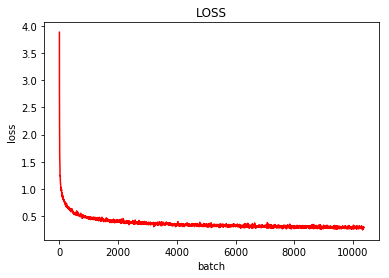

In [94]:
#LOSS
x = np.linspace(0, len(y), len(y))
y = loss_for_plot
plt.plot(x,y, color="red")
plt.plot()
plt.xlabel("batch")
plt.ylabel("loss")
plt.title("LOSS")

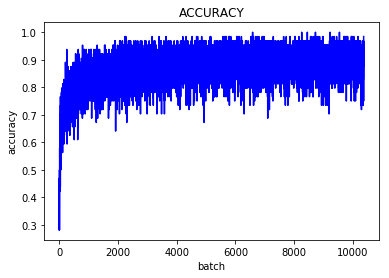

In [95]:
#ACCURACY
x = np.linspace(0, len(y_ac), len(y_ac))
y_ac = acc_for_plot
plt.plot(x,y_ac, color="blue")
plt.plot()
plt.xlabel("batch")
plt.ylabel("accuracy")
plt.title("ACCURACY")

# SHOW FEATURES

https://r2rt.com/implementing-batch-normalization-in-tensorflow.html